# Getting Started With Landsat Data  

| Authors:  | Claire Krause, Arapaut Sivaprasad|
|----------|----------------|
| Created: | May 14, 2018 |
| Last edited: | May 14, 2018 |

## Retrieve and plot the FC data from Landsats 5, 7 and 8  

**Background:** Data from three Landsats (5,7 and 8) are available to access within DEA. The code snippets in this doc will let you retrieve and plot the Fractional Cover (FC) data for **lsN_nbar_albers** and **lsN_nbart_albers**, where N is 5, 7 or 8 to denote the satellite.

**What does this document do?**

- Show how to open a datacube to retrieve the data for various time points and geo-coordinates.

- Explain the data corrections.

- Plot a scene as Fractional Cover (FC) image.

- Compare multiple scenes side-by-side.

**How to use this document:**

A basic understanding of *any* programming language is desirable, so that the code will make sense, but one doesn't have to be an expert Python programmer to manipulate the code to get and display the data. 

This doc applies to the following Landsats and data correction methods:

- Landsat 5
- Landsat 7
- Landsat 8
- NBAR

Given below are code snippets that you can execute to perform various actions such as retrieve, display and plot the data. If you wish to learn more about the code, as well as the satellites and how they collect the data, please go to this [document](GettingStartedWithLandSats5-7-8_Long.ipynb).

## How to retrieve and plot the data
Let us go through the process step by step. This is a Python program or a HTML page derived from one.  

In [19]:
%matplotlib inline
import datacube
import matplotlib.pyplot as plt
from skimage import exposure
import numpy as np

### See what products are currently available
The **list_products** method in the Datacube class displays the names and details of all available products. A product may be defined as the data collected by a particular satellite and reformatted. For example, **ls7_fc_albers**, is a set of data collected by the Landsat 7 as per the Australian Albers projected coordinate system, and the NBAR data correction applied. 

Given below are the products that are of interest to us in the context of this document. The code given below the list will let you see ALL products in the datacube.

|id 	| name 	| description|
|-|-|-|
|69 		| ls5_fc_albers 	| Landsat 5 Fractional Cover 25 metre, 100km til...|
|70 	| ls7_fc_albers 	| Landsat 7 Fractional Cover 25 metre, 100km til...|
|71 	| ls8_fc_albers 	| Landsat 8 Fractional Cover 25 metre, 100km til...|


#### Code to display the products

In [30]:
dc = datacube.Datacube(app='dc-metadata')
products = dc.list_products()
display_columns = ['name', 'description']
display_rows = [1]
dc_products = products[display_columns]
#dc_products # Activate this line to see all products

### Specify the *query* with the coordinates and date range

- **lat/lon:** Latitude and longitude of the area. e.g. Canberra = 'lat': (-35.25, -35.35), 'lon': (149.05, 149.17)
- **time:** Date range to fetch the scenes. The approximate time between two scenes is 16 days. If there is a location near a swath boundary, it may be captured in two passes and so there could be two images within the 16 day period.
    - You must know [the date(s) for which data is available](https://data.dea.gadevs.ga/ls7_nbar_scene) for each satellite/product, so that the query can be specified correctly. 

In [57]:
query = {
        'lat': (-35.25, -35.35),
        'lon': (149.05, 149.17),
        'time':('2017-01-01', '2017-03-15')
        }
#bands = ['PV', 'BS', 'BS']

### Now we actually load and look at some data
We will focus on data from the Landsats (5,7 and 8) for this demonstration. Sometimes multiple scenes are acquired by the satellite on the same day. We want to group these together, and will use **group_by='solar_day'** to do this. To load in the data, we need only to provide the geo-coordinates and time range.

### Create a data scene object
The return value from the load command below is an **xarray** object, which has two core data structures:

- **DataArray** is a labeled, N-dimensional array. 
- **Dataset** is a multi-dimensional, in-memory array database. It is a dict-like container of DataArray objects aligned along any number of shared dimensions, and serves a similar purpose in xarray to the **pandas.DataFrame**.


In [58]:
ds = dc.load(product='ls8_fc_albers', group_by='solar_day', **query)
ds

<xarray.Dataset>
Dimensions:  (time: 9, x: 492, y: 500)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-07T23:50:29 2017-01-14T23:56:38 ...
  * y        (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x        (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
Data variables:
    BS       (time, y, x) int8 72 72 72 71 72 72 71 72 71 71 71 71 71 71 71 ...
    PV       (time, y, x) int8 28 28 29 29 29 29 30 29 29 30 30 30 30 29 29 ...
    NPV      (time, y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
    UE       (time, y, x) int8 12 12 12 12 12 12 11 11 11 11 11 11 11 11 11 ...
Attributes:
    crs:      EPSG:3577

### Function to plot one image from the data

In [55]:
'''
    Last modified: April 2018
    Author: Mike Barnes
    Modified by: Claire Krause, Cate Kooymans, Robbi Bishop-Taylor, Sivaprasad Arapaut

Parameters for three_band_image():

Inputs:

    ds - dataset containing the bands to be plotted
    bands - list of three bands to be plotted

Optional:

    time - Index value of the time dimension of ds to be plotted.
        This index refers to the scenes captured, depending on your date range.
    figsize - dimensions for the output figure.
    contrast_enhance - determines the transformation for plotting onto RGB. If contrast_enhance = true, exposure.equalize_hist is used to transform the data. Else, the data are standardised relative to reflectance = 5000.
    title - string for the plot title. If nothing is given, it will print the names of the bands being plotted.
    projection - options are 'projected' or 'geographic'; determines if the image is in degrees or northings.
        The terms easting and northing are geographic Cartesian coordinates for a point. Easting refers to the eastward-measured distance (or the x-coordinate), while northing refers to the northward-measured distance (or the y-coordinate). Easting and northing coordinates are commonly measured in metres from the axes of some horizontal datum.
'''
def three_band_image(ds, bands, time=0, figsize=[10, 10], contrast_enhance=True, title='My Plot', projection='projected'):

    # Get the number of scenes and the number of x and y coordinates
    t, y, x = ds[bands[0]].shape

    # Initialise a numpy.ndarray class object with 0's
    rawimg = np.zeros((y, x, 3), dtype=np.float32)

    # Populate the rawimg array with actual values. These are taken from all specified bands
    for i, colour in enumerate(bands):
        rawimg[:, :, i] = ds[colour][time].values

    # If any value is recorded as -999, then change it to a NaN to make it an invalid data point
    rawimg[rawimg == -999] = np.nan
    
    # Enhance the picture quality by applying 'histogram_equalisation'
    if contrast_enhance:
        img_toshow = exposure.equalize_hist(rawimg, mask=np.isfinite(rawimg))
    else:
        img_toshow = rawimg / 5000
        
    # Plot the data
    fig = plt.figure(figsize=figsize)
    plt.imshow(img_toshow)
    
    # Build the X and Y axes
    ax = plt.gca()

    ax.set_title(str(ds.time[time].values), fontweight='bold', fontsize=16)
    ax.set_xticklabels(ds.x.values)
    ax.set_yticklabels(ds.y.values)
    
    ax.set_xlabel('Eastings', fontweight='bold')
    ax.set_ylabel('Northings', fontweight='bold')


### Plot an image of Bare Soil (BS)
The code blocks given below will plot a scene, specified as e.g. **time = 1**. Must remember that the index starts at 0 and if there is only one scene in the data, like what happens when the date range is less than ~16 days, you cannot display the second scene. In that case, **time = 0** must be given.

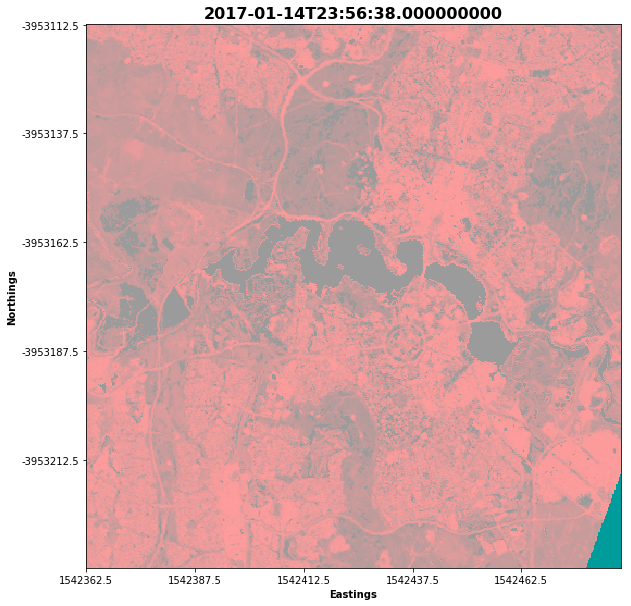

In [64]:
three_band_image(ds, bands=['BS'], time = 1)

### Plot an image of Photosynthetic Vegetation (PV)

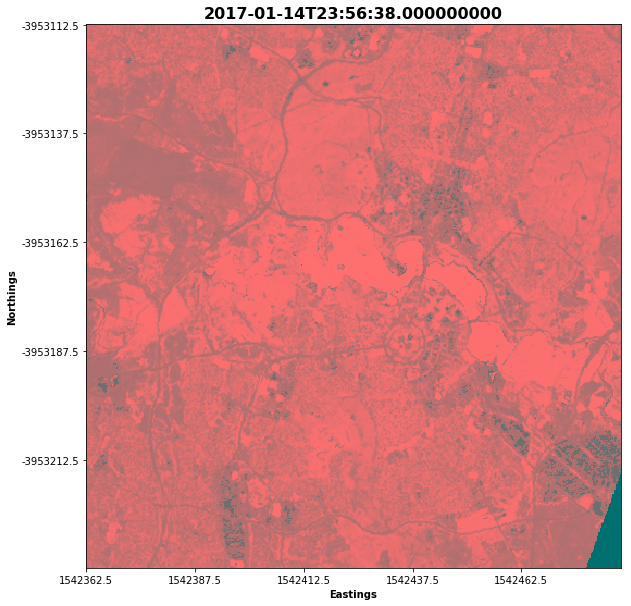

In [66]:
three_band_image(ds, bands=['PV'], time = 1)

### Plot an image of Non-Photosynthetic Vegetation (NPV)

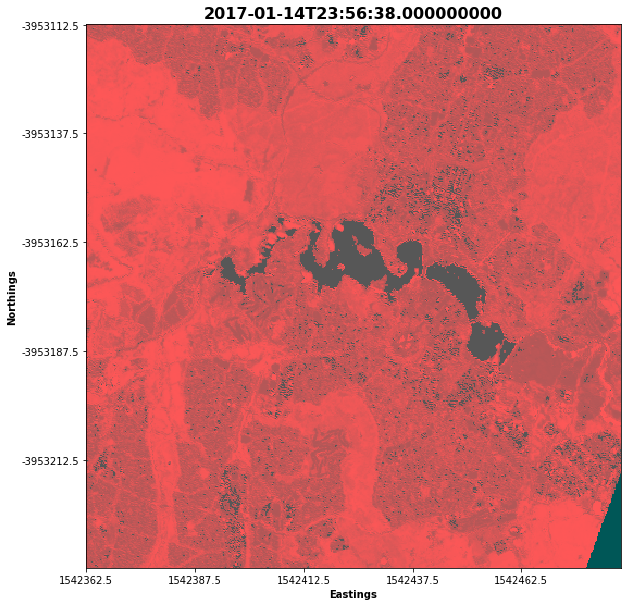

In [67]:
three_band_image(ds, bands=['NPV'], time = 1)